In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [52]:
df= pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [53]:
df=df[['price','sqft_living','bedrooms','bathrooms','floors','grade','yr_built','yr_renovated','waterfront']]

In [54]:
df.isnull().sum()
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.isnull().sum()
df.loc[df['yr_renovated'] > 0] = 1
df['yr_renovated']

0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
21592    0.0
21593    0.0
21594    0.0
21595    0.0
21596    0.0
Name: yr_renovated, Length: 21597, dtype: float64

In [55]:
df['waterfront'] = df['waterfront'].fillna(0)

In [56]:
df['waterfront'].unique()

array([0., 1.])

In [57]:
value_counts_bed=df['bedrooms'].value_counts()
to_remove = value_counts_bed[value_counts_bed <=50].index
df = df[~df.bedrooms.isin(to_remove)]

In [58]:
value_counts_bath=df['bathrooms'].value_counts()
to_remove_bath = value_counts_bath[value_counts_bath <=80].index
df = df[~df.bathrooms.isin(to_remove_bath)]

In [59]:
value_counts_floors=df['floors'].value_counts()
to_remove_floor = value_counts_floors[value_counts_floors <=10].index
df = df[~df.floors.isin(to_remove_floor)]

In [60]:
print(df.loc[df['yr_built'] == 1940])
df.drop(df[df.price == 1150000.0].index, inplace=True) 

           price  sqft_living  bedrooms  bathrooms  floors  grade  yr_built  \
241     210000.0          830         2       1.00     1.0      6      1940   
376     450000.0         1640         3       1.75     1.0      7      1940   
671     435000.0         1700         4       2.50     1.0      7      1940   
748     517500.0         1430         3       1.50     1.0      7      1940   
986     260000.0         1480         3       1.00     1.5      6      1940   
...          ...          ...       ...        ...     ...    ...       ...   
19320   345000.0         1080         2       1.00     1.0      7      1940   
19321   874950.0         1080         2       1.00     1.0      7      1940   
19397   445000.0         1150         2       2.00     1.0      7      1940   
19606  1150000.0         1760         3       1.75     2.0      7      1940   
21224   525000.0         1030         1       1.50     1.0      8      1940   

       yr_renovated  waterfront  
241             0

In [61]:
df.drop(df[df.price == 7060000.0].index, inplace=True) 

In [62]:
df.drop(df[df.price == 4490000.0].index, inplace=True) 

In [63]:
for x in ['price']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan
df.isnull().sum()
df = df.dropna(axis = 0)
df.isnull().sum()

price           0
sqft_living     0
bedrooms        0
bathrooms       0
floors          0
grade           0
yr_built        0
yr_renovated    0
waterfront      0
dtype: int64

In [64]:
df.head()

,price,sqft_living,bedrooms,bathrooms,floors,grade,yr_built,yr_renovated,waterfront
0,221900.0,1180,3,1.0,1.0,7,1955,0.0,0.0
1,1.0,1,1,1.0,1.0,1,1,1.0,1.0
2,180000.0,770,2,1.0,1.0,6,1933,0.0,0.0
3,604000.0,1960,4,3.0,1.0,7,1965,0.0,0.0
4,510000.0,1680,3,2.0,1.0,8,1987,0.0,0.0


In [65]:
outcome = 'price'
x_cols = ['sqft_living', 'bedrooms', 'bathrooms', 'floors', 'grade']

In [66]:
train, test = train_test_split(df)
print(len(train), len(test))
train.head()

15246 5082


,price,sqft_living,bedrooms,bathrooms,floors,grade,yr_built,yr_renovated,waterfront
13308,275000.0,1340,3,2.00,1.0,7,1944,0.0,0.0
12329,625000.0,2100,3,1.75,1.5,7,1912,0.0,0.0
3128,759000.0,1960,3,2.75,1.5,8,1900,0.0,0.0
10158,1.0,1,1,1.00,1.0,1,1,1.0,1.0
20928,925000.0,3420,5,3.50,2.0,9,2008,0.0,0.0


In [67]:
test.head()

,price,sqft_living,bedrooms,bathrooms,floors,grade,yr_built,yr_renovated,waterfront
5144,489000.0,3910,4,2.50,2.0,9,2000,0.0,0.0
6964,736500.0,3180,4,2.50,2.0,9,2000,0.0,0.0
19585,235000.0,1460,3,1.00,1.0,7,1958,0.0,0.0
20112,675000.0,1510,3,3.25,2.0,8,2008,0.0,0.0
3481,119900.0,700,2,1.00,1.0,6,1951,0.0,0.0


In [68]:
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     4779.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        06:26:37   Log-Likelihood:            -2.7079e+05
No. Observations:               20328   AIC:                         5.416e+05
Df Residuals:                   20322   BIC:                         5.416e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -8.521e+04   5875.977    -14.502      0.000   -9.67e+04   -7.37e+04
sqft_living   127.7023      2.435     52.450      0.000     122.930     132.475
bedrooms     -2.24e+04   1525.624    -14.683      0.000   -2.54e+04   -1.94e+04
bathrooms   -1.058e+04   2382.631     -4.442      0.000   -1.53e+04   -5913.932
floors       3494.7403   2347.568      1.489      0.137   -1106.682    8096.162
grade        5.297e+04   1007.243     52.589      0.000     5.1e+04    5.49e+04
==============================================================================
Omnibus:                     1109.276   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1316.736
Skew:                           0.582   Prob(JB):                    1.19e-286
Kurtosis:                       3.446   Cond. No.                     1.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
outcome = 'price'
x_cols = ['sqft_living', 'bedrooms', 'bathrooms', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5973.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        06:27:04   Log-Likelihood:            -2.7079e+05
No. Observations:               20328   AIC:                         5.416e+05
Df Residuals:                   20323   BIC:                         5.416e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -8.385e+04   5805.030    -14.445      0.000   -9.52e+04   -7.25e+04
sqft_living   127.4132      2.427     52.497      0.000     122.656     132.170
bedrooms    -2.269e+04   1513.643    -14.988      0.000   -2.57e+04   -1.97e+04
bathrooms   -9148.3867   2178.787     -4.199      0.000   -1.34e+04   -4877.788
grade        5.329e+04    984.218     54.144      0.000    5.14e+04    5.52e+04
==============================================================================
Omnibus:                     1106.194   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1312.520
Skew:                           0.581   Prob(JB):                    9.77e-286
Kurtosis:                       3.445   Cond. No.                     1.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

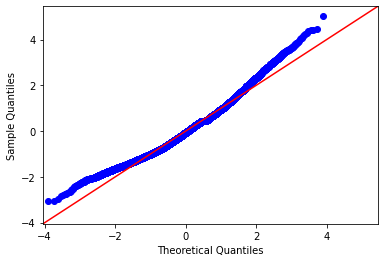

In [70]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

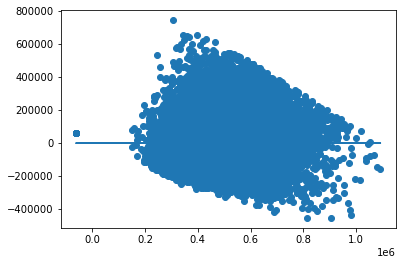

In [71]:
plt.scatter(model.predict(df[x_cols]), model.resid)
plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])

In [72]:
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('sqft_living', 17.509378555013594),
 ('bedrooms', 20.690001702759528),
 ('bathrooms', 19.211944215902253),
 ('grade', 24.1085568232464)]

In [73]:
for i in range(1, 50):
    q = i / 100
    print('{} percentile: {}'.format(q, df['price'].quantile(q=q)))

0.01 percentile: 1.0
0.02 percentile: 1.0
0.03 percentile: 1.0
0.04 percentile: 124040.00000000001
0.05 percentile: 163000.0
0.06 percentile: 180500.0
0.07 percentile: 196000.0
0.08 percentile: 205000.0
0.09 percentile: 213728.74999999997
0.1 percentile: 220000.0
0.11 percentile: 228998.5
0.12 percentile: 235000.0
0.13 percentile: 240000.0
0.14 percentile: 246000.0
0.15 percentile: 250000.0
0.16 percentile: 255000.0
0.17 percentile: 260000.0
0.18 percentile: 265500.0
0.19 percentile: 270000.0
0.2 percentile: 275000.0
0.21 percentile: 280000.0
0.22 percentile: 285000.0
0.23 percentile: 290000.0
0.24 percentile: 295215.9999999998
0.25 percentile: 300000.0
0.26 percentile: 305000.0
0.27 percentile: 310000.0
0.28 percentile: 315000.0
0.29 percentile: 320000.0
0.3 percentile: 325000.0
0.31 percentile: 329908.14
0.32 percentile: 333928.00000000006
0.33 percentile: 338500.0
0.34 percentile: 342500.0
0.35 percentile: 349000.0
0.36 percentile: 350000.0
0.37 percentile: 355000.0
0.38 percentile:

In [74]:
for i in range(75, 99):
    q = i / 100
    print('{} percentile: {}'.format(q, df['price'].quantile(q=q)))

0.75 percentile: 587126.5
0.76 percentile: 598104.0000000001
0.77 percentile: 605000.0
0.78 percentile: 615000.0
0.79 percentile: 625000.0
0.8 percentile: 635000.0
0.81 percentile: 646000.0
0.82 percentile: 655000.0
0.83 percentile: 666204.9999999999
0.84 percentile: 679950.0
0.85 percentile: 690690.0000000001
0.86 percentile: 704454.0000000008
0.87 percentile: 719255.2900000009
0.88 percentile: 732000.0
0.89 percentile: 750000.0
0.9 percentile: 760574.9999999998
0.91 percentile: 780000.0
0.92 percentile: 799000.0
0.93 percentile: 817027.5000000001
0.94 percentile: 840000.0
0.95 percentile: 860649.9999999978
0.96 percentile: 891459.9999999991
0.97 percentile: 925000.0
0.98 percentile: 960459.9999999991


In [76]:
subset = df[df['price'] < 720000]
print('Percent removed:',(len(df) - len(subset))/len(df))
outcome = 'price'
x_cols = ['sqft_living', 'bedrooms', 'bathrooms', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=subset).fit()
model.summary()

Percent removed: 0.12987012987012986


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     4157.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        06:27:24   Log-Likelihood:            -2.3147e+05
No. Observations:               17688   AIC:                         4.630e+05
Df Residuals:                   17683   BIC:                         4.630e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.472e+04   4770.537     -9.375      0.000   -5.41e+04   -3.54e+04
sqft_living    73.1023      2.266     32.263      0.000      68.661      77.544
bedrooms    -1.274e+04   1331.531     -9.570      0.000   -1.54e+04   -1.01e+04
bathrooms   -2773.1653   1854.213     -1.496      0.135   -6407.605     861.274
grade        5.062e+04    822.021     61.578      0.000     4.9e+04    5.22e+04
==============================================================================
Omnibus:                      552.062   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              488.387
Skew:                           0.348   Prob(JB):                    8.87e-107
Kurtosis:                       2.579   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

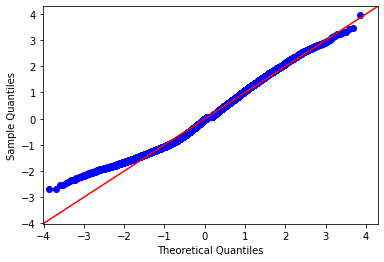

In [77]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)